In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import math

## Описание

In [75]:
df = pd.read_csv("diabetes.csv")
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Pedigree,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Pregnancies    768 non-null    int64  
 1   Glucose        768 non-null    int64  
 2   BloodPressure  768 non-null    int64  
 3   SkinThickness  768 non-null    int64  
 4   Insulin        768 non-null    int64  
 5   BMI            768 non-null    float64
 6   Pedigree       768 non-null    float64
 7   Age            768 non-null    int64  
 8   Outcome        768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Все значения не являются пустыми, нужно исключить нулевые значения

## Визуализация

array([[<Axes: title={'center': 'Pregnancies'}>,
        <Axes: title={'center': 'Glucose'}>,
        <Axes: title={'center': 'BloodPressure'}>],
       [<Axes: title={'center': 'SkinThickness'}>,
        <Axes: title={'center': 'Insulin'}>,
        <Axes: title={'center': 'BMI'}>],
       [<Axes: title={'center': 'Pedigree'}>,
        <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Outcome'}>]], dtype=object)

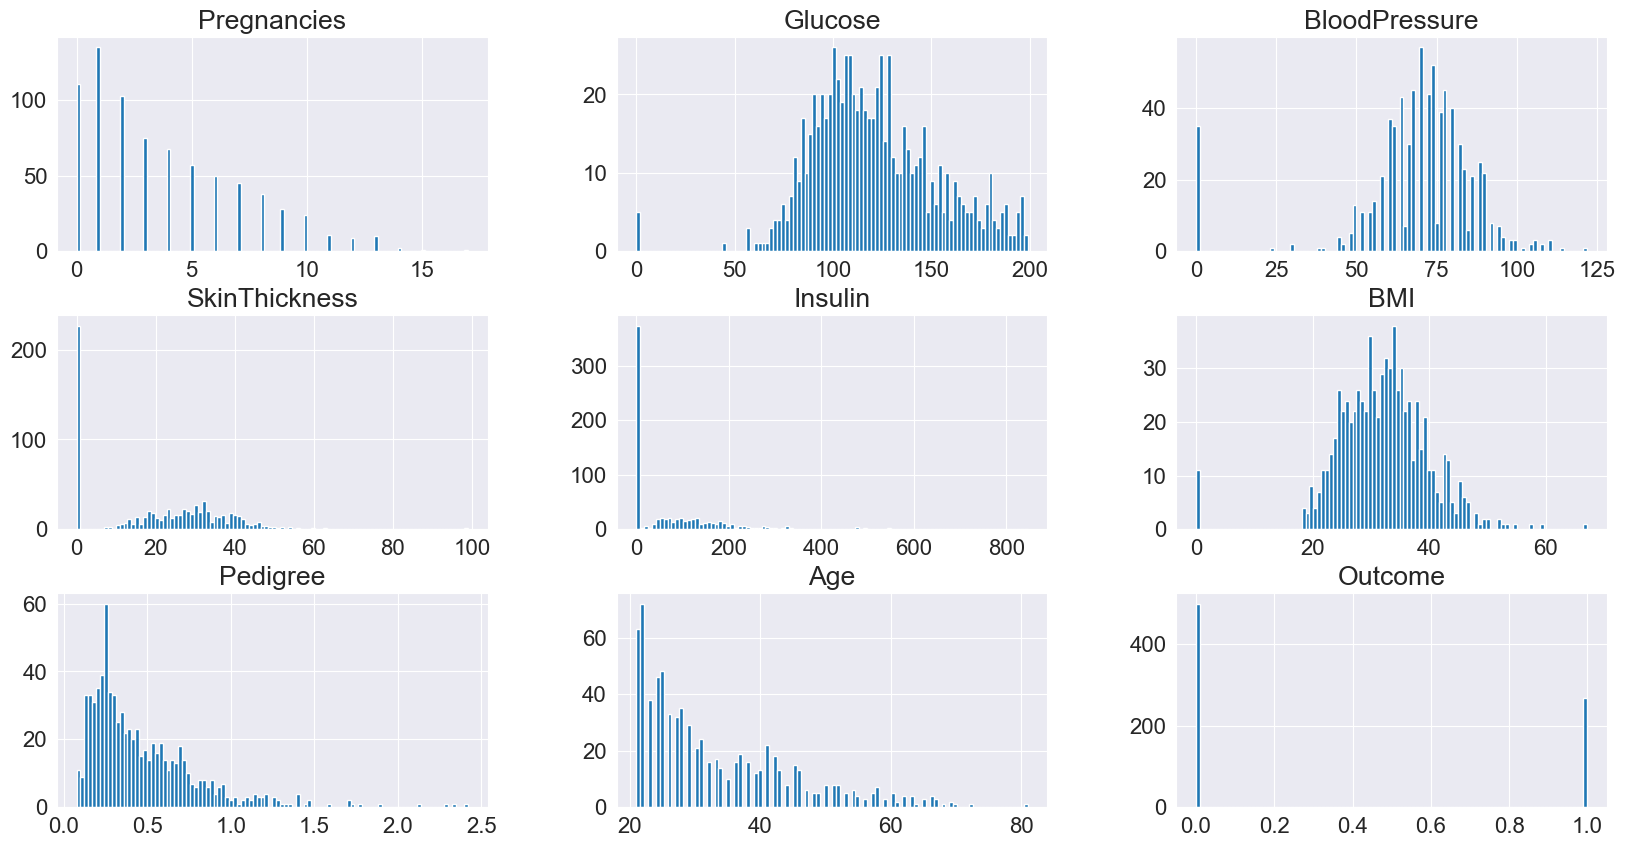

In [77]:
df.hist(bins=100, figsize=(20, 10))

## Очистка

Outcome - категориальный признак
Не все признаки обладают нормальным распределением, подлежат нормализации
Выбросим записи с нулевыми значениями

In [78]:
#Columns that contain empty values
columns_to_clean = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
# Remove null values
df = df[~df[columns_to_clean].isin([0]).any(axis=1)]

Избавимся дополнительно от выбросов
Колонка возраста не будет иметь выбросов, так как не имеет погрешности измерения

In [79]:
# Manually chosen to filter values
columns_to_cut_low = ['Glucose', 'BloodPressure']
columns_to_cut_high = ['SkinThickness', 'Insulin', 'BMI', 'Pedigree']
# Marked percentiles
low_percentiles = df[columns_to_cut_low].quantile(0.05)
high_percentiles = df[columns_to_cut_high].quantile(0.95)
# Marked rows
mask_low = df[columns_to_cut_low] < low_percentiles
mask_high = df[columns_to_cut_high] > high_percentiles
# Rows to exclude
combined_mask = mask_low.any(axis=1) | mask_high.any(axis=1)

df = df[~combined_mask]

Теперь построим матрицу корреляции и поймем, нужно ли исключить из выборки какие-либо признаки

<Axes: >

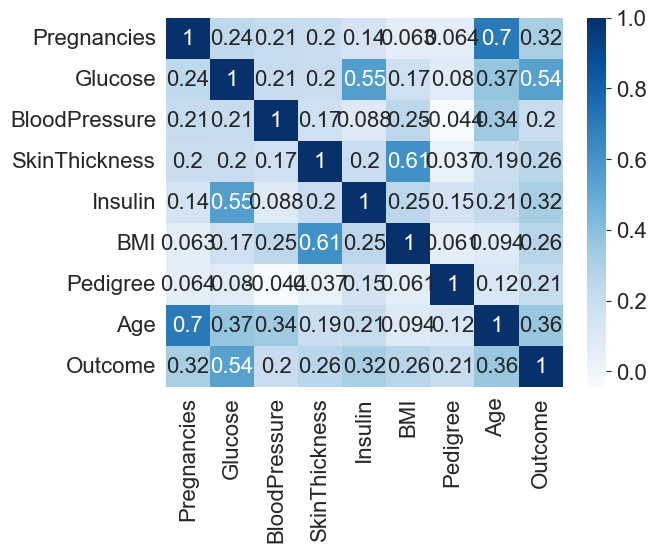

In [80]:
corr_matrix = df.corr()
sb.heatmap(corr_matrix, cmap="Blues", annot=True)

Признаки Age и Pregnancies имеют высокую корреляцию
Выбросим первый признак

array([[<Axes: title={'center': 'Glucose'}>,
        <Axes: title={'center': 'BloodPressure'}>,
        <Axes: title={'center': 'SkinThickness'}>],
       [<Axes: title={'center': 'Insulin'}>,
        <Axes: title={'center': 'BMI'}>,
        <Axes: title={'center': 'Pedigree'}>],
       [<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Outcome'}>, <Axes: >]], dtype=object)

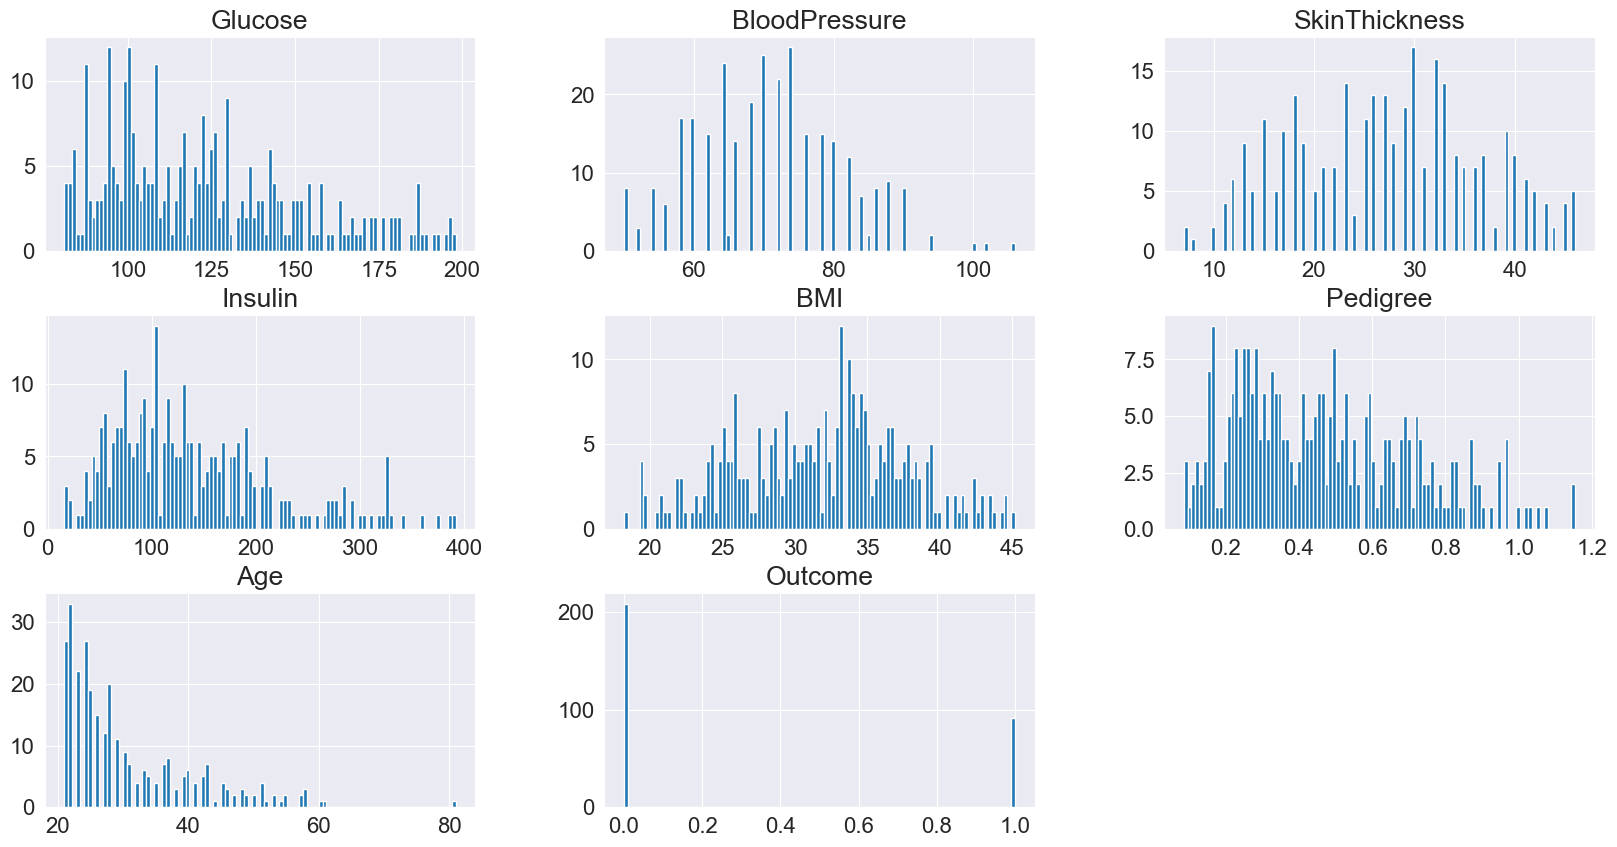

In [81]:
df.drop('Pregnancies', axis=1, inplace=True)

df.hist(bins=100, figsize=(20, 10))

## Нормализация

Заметим также, что записей с отрицательным результатом больше остальных. Отсечем датасет до равенства исходов

In [82]:
# Determine the desired number of samples per class
desired_samples = df['Outcome'].value_counts().min()
# desired_samples = 20

# Balance the dataset by randomly sampling rows from the majority class
df = df.groupby('Outcome').apply(lambda x: x.sample(desired_samples)).reset_index(drop=True)

Параметры Glucose, BloodPressure, Age распределены не нормально, для них применим медианную нормализацию
Для остальных параметров используем минимакс нормализацию

array([[<Axes: title={'center': 'Glucose'}>,
        <Axes: title={'center': 'BloodPressure'}>,
        <Axes: title={'center': 'SkinThickness'}>],
       [<Axes: title={'center': 'Insulin'}>,
        <Axes: title={'center': 'BMI'}>,
        <Axes: title={'center': 'Pedigree'}>],
       [<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Outcome'}>, <Axes: >]], dtype=object)

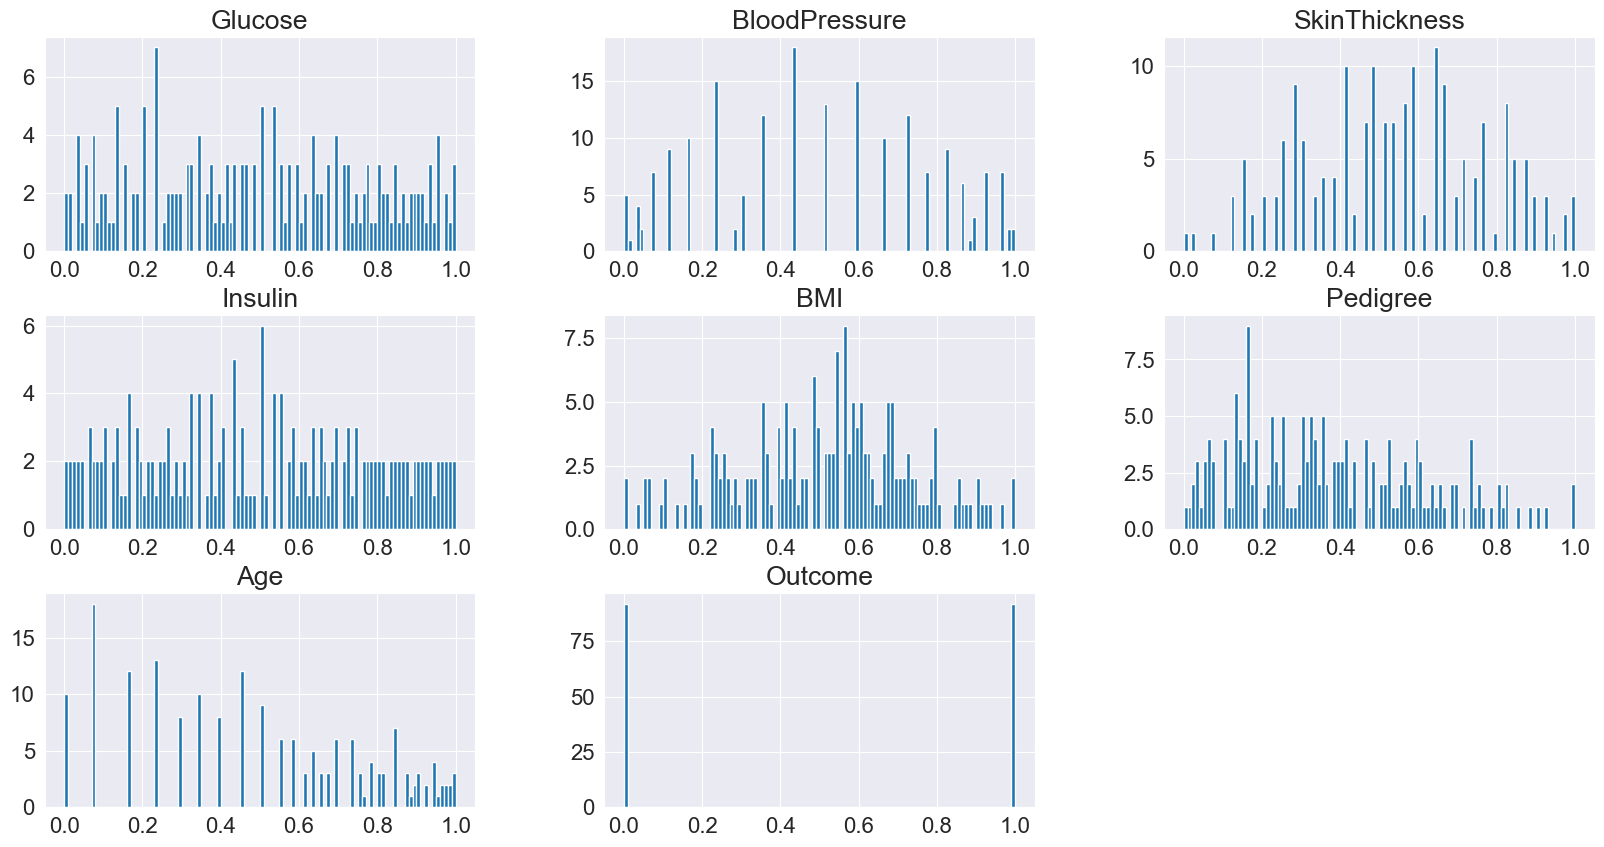

In [83]:
columns_to_transform = ['Glucose', 'BloodPressure', 'Age', 'Insulin']
columns_to_minmax_transform = ['SkinThickness', 'BMI', 'Pedigree']

# Step 1: Perform normalization
ranked_data = df[columns_to_transform].rank()
normalized_data = (ranked_data - ranked_data.min()) / (ranked_data.max() - ranked_data.min())

# Step 2: Scale to a range of 0 to 1
min_val = 0
max_val = 1
scaled_data = min_val + (max_val - min_val) * normalized_data

# Step 3: Replace the original columns with the normalized and scaled data
df[columns_to_transform] = scaled_data

# Step 4 normalize other data
df[columns_to_minmax_transform] = (df[columns_to_minmax_transform] - df[columns_to_minmax_transform].min()) / (df[columns_to_minmax_transform].max() - df[columns_to_minmax_transform].min())

df.hist(bins=100, figsize=(20, 10))


## KNN метод

### Train-test split

In [84]:
train_percentage = 0.8
random_state = 28

train = df.sample(frac=train_percentage, random_state=random_state)
test = df.drop(train.index)

train_x = train.drop('Outcome', axis=1)
train_y = train['Outcome']

print(train_y.value_counts())

test_x = test.drop('Outcome', axis=1)
test_y = test['Outcome']

print(test_y.value_counts())

Outcome
1    74
0    73
Name: count, dtype: int64
Outcome
0    19
1    18
Name: count, dtype: int64


### Predictor

In [85]:
class KNN:
    def __init__(self, ks: int, column_names: list[str]):
        self.x = None
        self.y = None
        self.ks = ks
        self.column_names = column_names

    def train(self, x, y):
        self.x = np.array(x[self.column_names])
        self.y = np.array(y)

    def pred(self, x):
        x = np.array(x[self.column_names]) # leave only listed columns
        ans = []

        for row in x:
            tmp = np.linalg.norm(self.x - row, axis=1, )
            # linalg.norm - count the matrix frobenius norm
            k_classes = self.y[tmp.argsort()[:self.ks]]
            # return the sorted indices in length vector
            # cast to classes
            classes, counts = np.unique(k_classes, return_counts=True)
            # count the classes
            winner = counts.argsort()[0]
            # take the most
            ans.append(classes[winner])

        return np.array(ans)

### Error matrix

In [86]:
def error_matrix(pred_y, true_y, n):
    res = np.zeros((n, n))

    for pred, true in zip(pred_y, true_y):
        res[int(pred), true] += 1

    return res

plt.rcParams.update({'font.size': 16})

def show_matrix(ax, pred_y, true_y, n):
    res = error_matrix(pred_y, true_y, n)
    ax.matshow(res)
    ax.set_xlabel('True class')
    ax.set_ylabel('Predicted class')

    for (i, j), z in np.ndenumerate(res):
        ax.text(j, i, str(int(z)), ha='center', va='center')

Случайный набор признаков

Случайно выбраны столбцы:
 Glucose


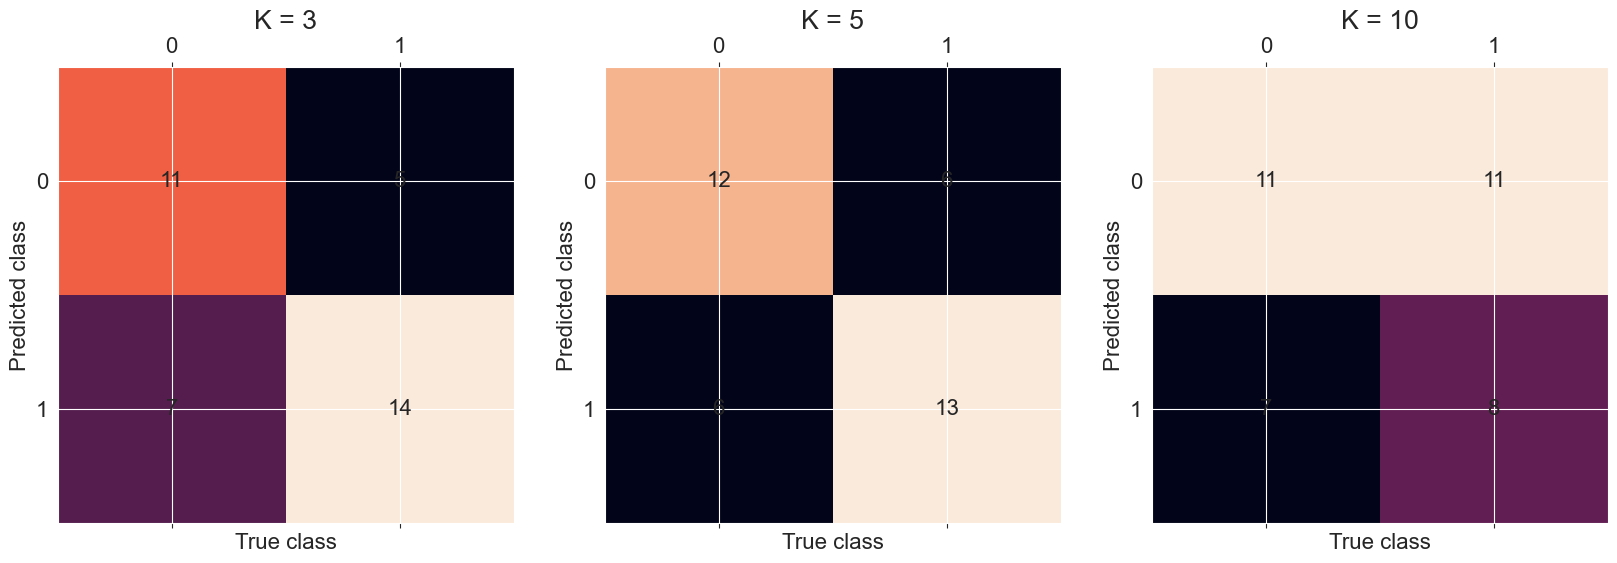

In [87]:
# col_names = np.random.choice(train_x.columns, size=np.random.randint(1, len(train_x.columns)), replace=False)
col_names = ['Glucose']
print('Случайно выбраны столбцы:\n', '\n'.join(col_names))

plt.figure(figsize=(20, 6))

for i, k in enumerate([3, 5, 10], 1):
    knn = KNN(k, col_names)
    knn.train(train_x, train_y)
    pred_y = knn.pred(test_x)

    ax = plt.subplot(1, 3, i)
    ax.set_title('K = %d' %k)

    show_matrix(ax, pred_y-1, test_y-1, 2)

Набор из всех признаков

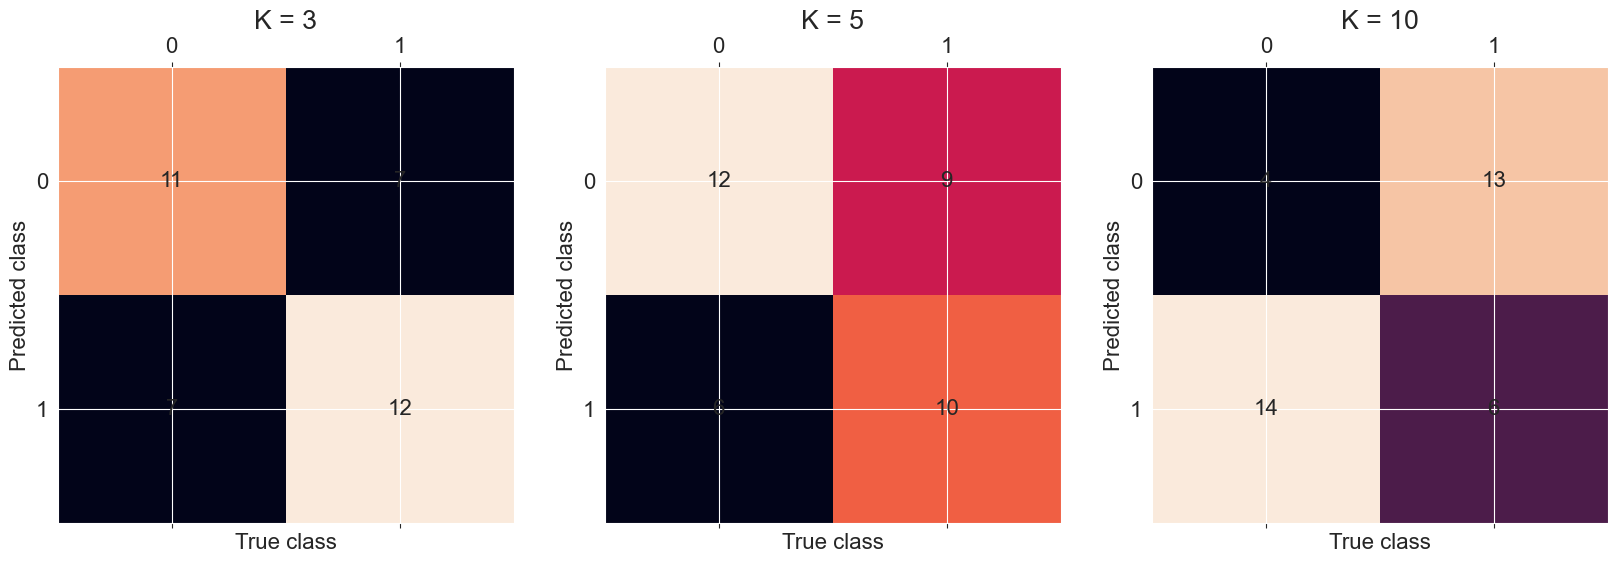

In [88]:
plt.figure(figsize=(20, 6))

for i, k in enumerate([3, 5, 10], 1):
    knn = KNN(k, train_x.columns)
    knn.train(train_x, train_y)
    pred_y = knn.pred(test_x)

    ax = plt.subplot(1, 3, i)
    ax.set_title('K = %d' %k)

    show_matrix(ax, pred_y-1, test_y-1, 2)